# Human Activity Detector Model

In [1]:
!pip install ultralytics mediapipe --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 40.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 29.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torchvision import transforms, models
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import joblib

# ultralytics YOLO API
from ultralytics import YOLO

# MediaPipe
import mediapipe as mp

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


E0000 00:00:1760638553.118997      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760638553.175017      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Coba pakai cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## Import Dataset

In [ ]:
DATA_ROOT = Path("dataset")
OUTPUT_DIR = "./model"
TRAIN_IMG_DIR = DATA_ROOT / "train"
TEST_IMG_DIR = DATA_ROOT / "test"
TRAIN_CSV = DATA_ROOT / "Training_set.csv"
TEST_CSV = DATA_ROOT / "Testing_set.csv"

EPOCH_AMOUNT = 15

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

In [5]:
print("Train samples:", len(train_df))
print("Test samples:", len(test_df))

Train samples: 12600
Test samples: 5400


## Importing YOLOv11n

In [6]:
yolo_model = YOLO("yolo12n.pt")

sample_img = str(TRAIN_IMG_DIR / train_df.iloc[0]["filename"])
res = yolo_model.predict(source=sample_img, imgsz=640, conf=0.25, device=0 if torch.cuda.is_available() else "cpu", verbose=False)
print("YOLO inference OK, boxes found:", len(res[0].boxes) if res else 0)

YOLO inference OK, boxes found: 1


In [7]:
# Cell 5: function to get largest-person crop (as image array, not saving)
def get_largest_person_crop(image_path, yolo_model, conf_thresh=0.25):
    results = yolo_model.predict(
        source=str(image_path),
        imgsz=640,
        conf=conf_thresh,
        device=0 if torch.cuda.is_available() else "cpu",
        verbose=False
    )
    if not results:
        return None
    r = results[0]
    if r.boxes is None or len(r.boxes) == 0:
        return None

    boxes = []
    for b in r.boxes:
        xyxy = b.xyxy.cpu().numpy().flatten().tolist()
        boxes.append(xyxy)
    # choose largest box
    best = max(boxes, key=lambda xyxy: (xyxy[2]-xyxy[0])*(xyxy[3]-xyxy[1]))
    x1, y1, x2, y2 = map(int, best)
    img = cv2.imread(str(image_path))
    if img is None:
        return None
    h, w, _ = img.shape
    x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)
    if x2 <= x1 or y2 <= y1:
        return None
    return img[y1:y2, x1:x2]


In [8]:
# Cell 6: extract mediapipe pose landmarks directly from YOLO crops
mp_pose = mp.solutions.pose
pose_detector = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=1)

def extract_pose_from_image(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    res = pose_detector.process(img_rgb)
    if not res or not res.pose_landmarks:
        return np.zeros(33*4, dtype=np.float32)
    lm = []
    for l in res.pose_landmarks.landmark:
        lm.extend([l.x, l.y, l.z, l.visibility])
    return np.array(lm, dtype=np.float32)


In [9]:
class YOLOCropImageDataset(Dataset):
    def __init__(self, df, img_dir, yolo_model, pose_detector, label_encoder=None, is_train=True, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.yolo_model = yolo_model
        self.pose_detector = pose_detector
        self.le = label_encoder
        self.is_train = is_train
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / row["filename"]
        crop = get_largest_person_crop(img_path, self.yolo_model)
        if crop is None:
            crop = np.zeros((224,224,3), dtype=np.uint8)
        img = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        if self.transform:
            img = self.transform(img)
        if self.is_train:
            y = int(self.le.transform([row["label"]])[0])
            return img, y
        else:
            return img, row["filename"]

transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])
transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [10]:
# Cell 8: prepare datasets
le = LabelEncoder()
le.fit(train_df["label"])
train_idx, val_idx = train_test_split(
    np.arange(len(train_df)), test_size=0.15, stratify=train_df["label"], random_state=42
)
train_sub = train_df.iloc[train_idx].reset_index(drop=True)
val_sub = train_df.iloc[val_idx].reset_index(drop=True)

train_dataset = YOLOCropImageDataset(train_sub, TRAIN_IMG_DIR, yolo_model, pose_detector, le, True, transform_train)
val_dataset = YOLOCropImageDataset(val_sub, TRAIN_IMG_DIR, yolo_model, pose_detector, le, True, transform_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [11]:
joblib.dump(le, OUTPUT_DIR + "/label_encoder.pkl")

['/kaggle/working/label_encoder.pkl']

## Using ResNet

In [12]:
# Cell 12: ResNet18 fine-tuning on YOLO crops
resnet = models.resnet101(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, len(le.classes_))
resnet = resnet.to(device)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(resnet.parameters(), lr=1e-4)

def train_resnet_epoch(model, loader):
    model.train()
    total_loss, preds, trues = [], [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer2.zero_grad()
        logits = model(x)
        loss = criterion2(logits, y)
        loss.backward()
        optimizer2.step()
        total_loss.append(loss.item())
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        trues.extend(y.cpu().numpy())
    return np.mean(total_loss), accuracy_score(trues, preds)

def eval_resnet_epoch(model, loader):
    model.eval()
    total_loss, preds, trues = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion2(logits, y)
            total_loss.append(loss.item())
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            trues.extend(y.cpu().numpy())
    return np.mean(total_loss), accuracy_score(trues, preds)

best_resnet_acc = 0
for epoch in range(1, EPOCH_AMOUNT):
    tr_loss, tr_acc = train_resnet_epoch(resnet, train_loader)
    val_loss, val_acc = eval_resnet_epoch(resnet, val_loader)
    print(f"[ResNet] Epoch {epoch:02d} | Train {tr_acc:.3f} | Val {val_acc:.3f}")
    if val_acc > best_resnet_acc:
        best_resnet_acc = val_acc
        torch.save(resnet.state_dict(), OUTPUT_DIR + "/best_resnet_yolo.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
W0000 00:00:1760638566.298567     127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760638566.363990     127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Downloading

[ResNet] Epoch 01 | Train 0.636 | Val 0.681
[ResNet] Epoch 02 | Train 0.794 | Val 0.727
[ResNet] Epoch 03 | Train 0.861 | Val 0.722
[ResNet] Epoch 04 | Train 0.903 | Val 0.728
[ResNet] Epoch 05 | Train 0.922 | Val 0.734
[ResNet] Epoch 06 | Train 0.939 | Val 0.741
[ResNet] Epoch 07 | Train 0.951 | Val 0.740
[ResNet] Epoch 08 | Train 0.955 | Val 0.728
[ResNet] Epoch 09 | Train 0.954 | Val 0.735
[ResNet] Epoch 10 | Train 0.966 | Val 0.713
[ResNet] Epoch 11 | Train 0.969 | Val 0.733
[ResNet] Epoch 12 | Train 0.959 | Val 0.730
[ResNet] Epoch 13 | Train 0.961 | Val 0.709
[ResNet] Epoch 14 | Train 0.963 | Val 0.721


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


=== YOLO Crops + ResNet Classification Report ===
                    precision    recall  f1-score   support

           calling       0.76      0.64      0.70       126
          clapping       0.60      0.80      0.69       126
           cycling       0.97      0.88      0.93       126
           dancing       0.76      0.67      0.71       126
          drinking       0.83      0.75      0.79       126
            eating       0.88      0.78      0.83       126
          fighting       0.66      0.75      0.70       126
           hugging       0.72      0.87      0.78       126
          laughing       0.74      0.80      0.77       126
listening_to_music       0.82      0.70      0.76       126
           running       0.76      0.80      0.78       126
           sitting       0.62      0.55      0.58       126
          sleeping       0.72      0.83      0.77       126
           texting       0.65      0.69      0.67       126
      using_laptop       0.75      0.60      0.66

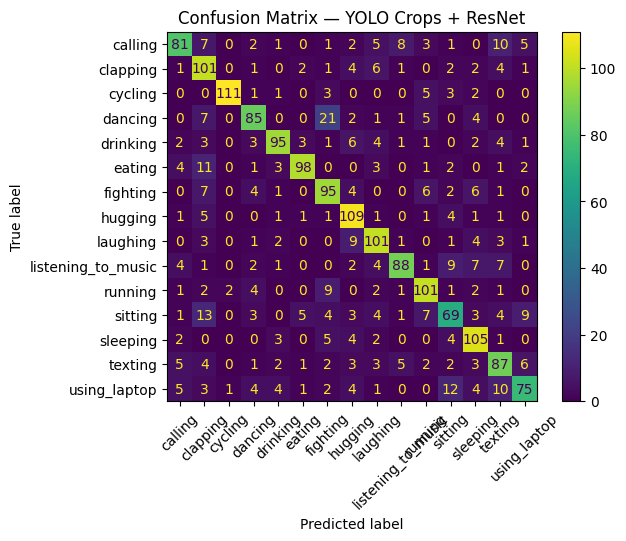

In [13]:
# Cell 14: evaluation — classification report & confusion matrix (YOLO crops + ResNet)
# reload best ResNet model
resnet_best = models.resnet101(pretrained=False)
resnet_best.fc = nn.Linear(resnet_best.fc.in_features, len(le.classes_))
resnet_best.load_state_dict(torch.load(OUTPUT_DIR + "/best_resnet_yolo.pth", map_location=device))
resnet_best.to(device)
resnet_best.eval()

y_true_res, y_pred_res = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        logits = resnet_best(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_res.extend(preds)
        y_true_res.extend(y.cpu().numpy())

print("=== YOLO Crops + ResNet Classification Report ===")
print(classification_report(y_true_res, y_pred_res, target_names=le.classes_, zero_division=0))

cm_res = confusion_matrix(y_true_res, y_pred_res)
disp_res = ConfusionMatrixDisplay(confusion_matrix=cm_res, display_labels=le.classes_)
disp_res.plot(xticks_rotation=45)
plt.title("Confusion Matrix — YOLO Crops + ResNet")
plt.show()
